# Data Preperation
This Jupyter Notebook is the first Notebook from a series of Notebooks that make use of a Convolutional Neural Network to perform land classification. This notebook outlines the steps involved in preparing the EuroSAT Sentinel 2 Dataset for the training of the CNN model. The preparation process of the dataset include:
1. The **importing** of the necessary librares including os, shutil, random and gdal

### Importing Necessary Libraries

In [47]:
# File handling and manipulation
import os  # Provides functions for interacting with the operating system, such as reading and writing files and directories.
import shutil  # Offers high-level file operations like copying and moving files.
from PIL import Image  # Python Imaging Library (PIL) for opening, manipulating, and saving image files.

# Data manipulation and analysis
import pandas as pd  # Data analysis and manipulation library providing data structures like DataFrames.
import numpy as np  # Provides support for large arrays and matrices, along with mathematical functions to operate on these arrays.

# Geospatial data processing
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.plot import show  # Function for visualizing raster data.

# Visualization and plotting
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations in Python.
import seaborn as sns  # Data visualization library based on matplotlib, providing a high-level interface for drawing attractive statistical graphics.

# Utilities
import random  # Provides functions for generating random numbers and performing random operations.
from tqdm import tqdm  # Library for displaying progress bars in loops or processes.
import textwrap  # Utilities for wrapping and formatting text to fit a specific width.

### Loading Metadata and Defining Base Directories

In [8]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')

# Base directories
source_base_dir = r'D:\datasets\2020-BigEarthNet-S2'
destination_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset'

### Inspecting the Meta Data

In [32]:
# Get the number of rows in the DataFrame
num_rows = metadata_df.shape[0]

# Print the number of rows in the DataFrame, followed by a blank line
print(f"The DataFrame contains {num_rows} rows.\n")

# Display the column names in the DataFrame, followed by a blank line
print("Column Names:")
print(metadata_df.columns, "\n")

# Display the first few rows of the DataFrame with a preceding message
print("First few rows of the DataFrame:")
print(metadata_df.head())

The DataFrame contains 480038 rows.

Column Names:
Index(['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name',
       'contains_seasonal_snow', 'contains_cloud_or_shadow'],
      dtype='object') 

First few rows of the DataFrame:
                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                              labels split  country  \
0  [Arable land, Broad-leaved forest, Mixed fores...  test  Austria   
1  [Arable land, Broad-leaved forest, Inland wate...  test  Austria   
2  [Arable land, Broad-leaved forest, Coniferous ...  test  Austria   
3  [Broad-leaved forest, Complex cultivation patt...  test  Austria   
4  [Broad-leaved forest, Complex cultivation patt...  test  Austr

### Extracting Unique Labels and Creating Directories

In [35]:
# Extract unique labels from the metadata dataframe
unique_labels = metadata_df['labels'].explode().unique()

# Print the unique labels in a numbered table format
print("Unique Labels:")
for i, label in enumerate(unique_labels, start=1):
    print(f"{i}. {label}")

print()

# Create directories for each label with progress bar
for label in tqdm(unique_labels, desc="Creating directories"):
    label_dir = os.path.join(destination_base_dir, label)
    
    # Create the directory if it does not exist
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

print("All directories have been created.") # Output to indicate directory creation completion

Unique Labels:
1. Arable land
2. Broad-leaved forest
3. Mixed forest
4. Pastures
5. Inland waters
6. Coniferous forest
7. Complex cultivation patterns
8. Land principally occupied by agriculture, with significant areas of natural vegetation
9. Urban fabric
10. Industrial or commercial units
11. Inland wetlands
12. Transitional woodland, shrub
13. Natural grassland and sparsely vegetated areas
14. Moors, heathland and sclerophyllous vegetation
15. Marine waters
16. Coastal wetlands
17. Permanent crops
18. Beaches, dunes, sands
19. Agro-forestry areas



Creating directories: 100%|██████████| 19/19 [00:00<00:00, 1904.18it/s]

All directories have been created.


### Processing and Distributing Images to their appropriate category based on Metadata 

In [7]:
# Function to process each image
def process_image(image_folder_path, labels):
    try:
        # Process each label
        for label in labels:
            dest_dir = os.path.join(destination_base_dir, label)

            # Create the directory if it does not exist
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir, exist_ok=True)

            # Construct the destination path for each label
            dest_folder_path = os.path.join(dest_dir, os.path.basename(image_folder_path))

            # Check if the destination folder already exists
            if not os.path.exists(dest_folder_path):
                # Copy the folder
                shutil.copytree(image_folder_path, dest_folder_path)

        # Remove the source directory after copying all the labels
        shutil.rmtree(image_folder_path)
    except Exception as e:
        print(f"Error processing folder {image_folder_path}: {e}")

# Count total images to process, excluding 'BigEarthNetDataset'
total_images = 0
for date_folder in os.listdir(source_base_dir):
    if date_folder == 'BigEarthNetDataset':
        continue  # Skip this folder
    date_folder_path = os.path.join(source_base_dir, date_folder)
    if os.path.isdir(date_folder_path):
        image_folders = [f for f in os.listdir(date_folder_path) if os.path.isdir(os.path.join(date_folder_path, f))]
        num_images = len(image_folders)
        total_images += num_images

# Create a progress bar for processing images
with tqdm(total=total_images, desc="Processing Images") as pbar:
    # Iterate through each date folder
    for date_folder in os.listdir(source_base_dir):
        if date_folder == 'BigEarthNetDataset':
            continue  # Skip this folder
        date_folder_path = os.path.join(source_base_dir, date_folder)
        
        if os.path.isdir(date_folder_path):
            # Iterate through each image folder within the date folder
            for image_folder in os.listdir(date_folder_path):
                image_folder_path = os.path.join(date_folder_path, image_folder)
                
                if os.path.isdir(image_folder_path):
                    # Find the corresponding metadata row
                    patch_id = image_folder
                    row = metadata_df[metadata_df['patch_id'] == patch_id]
                    
                    if not row.empty:
                        labels = row.iloc[0]['labels']
                        process_image(image_folder_path, labels)
                    
                    # Update progress bar after processing each image
                    pbar.update(1)

print("Processing complete.")

Processing Images: 100%|██████████| 422728/422728 [10:04:23<00:00, 11.66it/s]  


Processing complete.


### Moving Unwanted Directories to 'Snow_Cloud_Shadow_patches' Folder

In [16]:
# Define the source base directory
destination_dir = os.path.join(source_base_dir, 'Snow_Cloud_Shadow_patches')

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List all items in the source base directory
items = [item_name for item_name in os.listdir(source_base_dir) 
         if os.path.isdir(os.path.join(source_base_dir, item_name)) and item_name != 'BigEarthNetDataset']

# Initialize the progress bar
for item_name in tqdm(items, desc='Moving directories', unit='dir'):
    # Full path to the item
    item_path = os.path.join(source_base_dir, item_name)

    # Move the directory and its contents to the destination directory
    shutil.move(item_path, destination_dir)

print("Folders moved successfully to 'Snow_Cloud_Shadow_patches'.")

Moving directories: 100%|██████████| 116/116 [00:00<00:00, 1997.65dir/s]

Folders moved successfully to 'Snow_Cloud_Shadow_patches'.


### Deleting any Empty Folders from the Snow_Cloud_Shadow_patches Directory

In [ ]:
def remove_empty_folders(directory):
    # Walk through the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            # Check if the directory is empty
            if not os.listdir(dir_path):
                # Remove the empty directory
                os.rmdir(dir_path)
                print(f"Removed empty directory: {dir_path}")

# Define the directory containing the empty folders
target_directory = r'D:\datasets\2020-BigEarthNet-S2\Snow_Cloud_Shadow_patches'

remove_empty_folders(target_directory)

### Counting and Displaying the number of images within each category

In [39]:
# Initialize a dictionary to hold the count of subfolders in each folder
folder_subfolder_counts = {}

# Iterate through each item in the base directory with a progress bar
for folder in tqdm(os.listdir(destination_base_dir), desc="Processing Folders", unit="folder"):
    folder_path = os.path.join(destination_base_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # List all subdirectories within the current folder
        subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]
        
        # Count the number of subfolders
        subfolder_count = len(subfolders)
        
        # Store the count in the dictionary
        folder_subfolder_counts[folder] = subfolder_count

# Convert dictionary to DataFrame
df_folder_counts = pd.DataFrame(list(folder_subfolder_counts.items()), columns=['Folder', 'Subfolder Count'])

# Sort the DataFrame by 'Subfolder Count' in descending order
df_folder_counts = df_folder_counts.sort_values(by='Subfolder Count', ascending=False)

# Print header
print(f"{'Folder Name':<70} {'Subfolder Count':>15}")
print("-" * 85)

# Print the sorted number of subfolders in each folder in a formatted manner
for folder, count in df_folder_counts.itertuples(index=False):
    print(f"{folder:<70} {count:>15}")

Processing Folders: 100%|██████████| 19/19 [05:29<00:00, 17.34s/folder]

Folder Name                                                            Subfolder Count
-------------------------------------------------------------------------------------
Arable land                                                                     188025
Mixed forest                                                                    165780
Coniferous forest                                                               154941
Transitional woodland, shrub                                                    141150
Broad-leaved forest                                                             135928
Land principally occupied by agriculture, with significant areas of natural vegetation          122709
Complex cultivation patterns                                                     99598
Pastures                                                                         95605
Urban fabric                                                                     63758
Inland waters               

### Generating and Saving a Bar Plot for the amount of images in each category

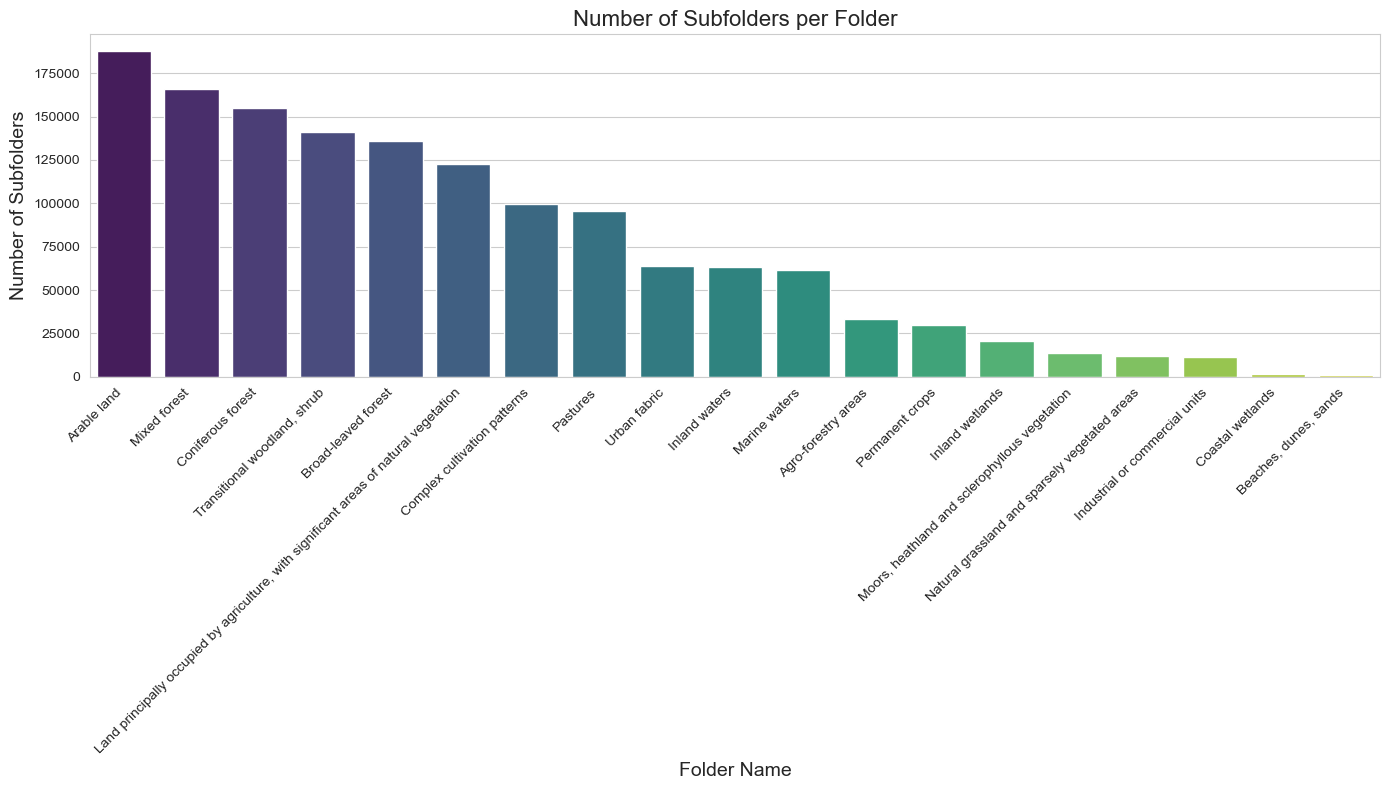

In [60]:
# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Folder', y='Subfolder Count', data=df_folder_counts, hue='Folder', palette='viridis', legend=False)

# Add titles and labels
plt.title('Number of Subfolders per Folder', fontsize=16)
plt.xlabel('Folder Name', fontsize=14)
plt.ylabel('Number of Subfolders', fontsize=14)

# Rotate and wrap the x-axis labels
plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees and align them right
ax = plt.gca()  # Get the current Axes object
for label in ax.get_xticklabels():
    label.set_text("\n".join(textwrap.wrap(label.get_text(), width=15)))  # Wrap each label's text

# Show the plot
plt.tight_layout() 

# Create the 'images' folder if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Save the plot within the 'images' folder
plt.savefig('images/original_categories_barplot.png')  
plt.show()

### Creating Directory Structure for Dataset Splits and Labels

In [10]:
# Dataset splits directory
dataset_splits_dir = os.path.join(destination_base_dir, 'dataset_splits')

# Split types
splits = ['train', 'valid', 'test']

# Step 1: Create the 'dataset_splits' directory
os.makedirs(dataset_splits_dir, exist_ok=True)

# Step 2: Create the directories for each split and each unique label
for split in splits:
    split_dir = os.path.join(dataset_splits_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    
    for label in unique_labels:
        # Replace any invalid characters in label names for directories if necessary
        label_dir_name = label.replace("/", "_")  
        label_dir = os.path.join(split_dir, label_dir_name)
        os.makedirs(label_dir, exist_ok=True)

print(f"Directories created successfully under '{dataset_splits_dir}'.")

Directories created successfully under 'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits'.


### Calculating and Displaying Distribution of Samples Across Dataset Splits

In [8]:
# Calculate the total number of records in the dataset
total_records = len(metadata_df)

# Filter the DataFrame for each split
train_df = metadata_df[metadata_df['split'] == 'train']
val_df = metadata_df[metadata_df['split'] == 'validation']
test_df = metadata_df[metadata_df['split'] == 'test']

# Calculate the number of samples in each split
train_samples = len(train_df)
val_samples = len(val_df)
test_samples = len(test_df)

# Calculate the percentage of each split
train_percentage = (train_samples / total_records) * 100
val_percentage = (val_samples / total_records) * 100
test_percentage = (test_samples / total_records) * 100

# Display the number of samples and percentage for each split
print(f"Training samples: {train_samples} ({train_percentage:.2f}%)")
print(f"Validation samples: {val_samples} ({val_percentage:.2f}%)")
print(f"Test samples: {test_samples} ({test_percentage:.2f}%)")

Training samples: 237871 (49.55%)
Validation samples: 122342 (25.49%)
Test samples: 119825 (24.96%)


### Moving Data from Categories to the Test/Train and Validation folders based on the Meta Data

In [9]:
# TO move the data from the 19 categories to the appropriate category in TEST/TRAIN/VALID these are the steps you should do:
# Step 1: Iterate through every patch_id in the meta data file
# Step 2: For each item, get the appropriate labels and split location
# Step 3: Go to all the folders with matching labels and simply move them to the folders in the defined split
# Step 4: Repeat until all the data have been moved to the appropriate locations

source_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset'
target_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits'

os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'valid'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)

def move_folders_based_on_metadata(df, source_base_dir, target_base_dir):
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Moving Folders"):
        patch_id = row['patch_id']
        split = row['split']
        labels = row['labels']

        for label in labels:
            source_path = os.path.join(source_base_dir, label, patch_id)
            target_path = os.path.join(target_base_dir, split, label)

            try:
                shutil.move(source_path, target_path)
            except FileNotFoundError:
                pass
            except Exception as e:
                print(f"Error moving {source_path} to {target_path}: {e}")
                
# Move the folders based on the metadata
move_folders_based_on_metadata(metadata_df, source_base_dir, target_base_dir)

print("Folders moved successfully.")

Moving Folders: 100%|██████████| 480038/480038 [16:33<00:00, 483.42it/s] 

Folders moved successfully.


### Function used to calculate the number of images within each split folder

In [42]:
def count_folders_in_split(base_dir, split_name):
    split_dir = os.path.join(base_dir, split_name)
    
    # Check if the directory exists
    if not os.path.isdir(split_dir):
        raise FileNotFoundError(f"Directory not found: {split_dir}")

    category_counts = {}
    
    # Get all the category directories within the split directory
    categories = [category for category in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, category))]
    
    for category in tqdm(categories, desc=f"Counting folders in '{split_name}'", unit="category"):
        category_path = os.path.join(split_dir, category)
        if os.path.isdir(category_path):
            # Count the number of subfolders in each category folder
            num_folders = len([folder for folder in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, folder))])
            category_counts[category] = num_folders
    
    return category_counts

### Function used to plot and save the category distributions for the splits

In [45]:
# Function to plot and save the category distribution as an image
def plot_category_distribution(category_counts, split_name, save_path=None):
    # Sort categories by counts in ascending order
    sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1]))
    categories = list(sorted_counts.keys())
    counts = list(sorted_counts.values())
    
    plt.figure(figsize=(12, 8))
    plt.barh(categories, counts, color='skyblue')
    plt.xlabel('Number of Folders')
    plt.title(f'Folder Distribution in {split_name} Split')
    plt.gca().invert_yaxis()  # To have the category with the most folders at the top
    
    if save_path:
        # Save the figure to the specified path, adjusting to ensure nothing is cut off
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

### Calculating and Visualising Dataset Split Distributions

Checking path: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\train


Counting folders in 'train': 100%|██████████| 19/19 [02:10<00:00,  6.89s/category]


Checking path: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\test


Counting folders in 'test': 100%|██████████| 19/19 [01:04<00:00,  3.39s/category]


Checking path: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits\validation


Counting folders in 'validation': 100%|██████████| 19/19 [01:09<00:00,  3.68s/category]


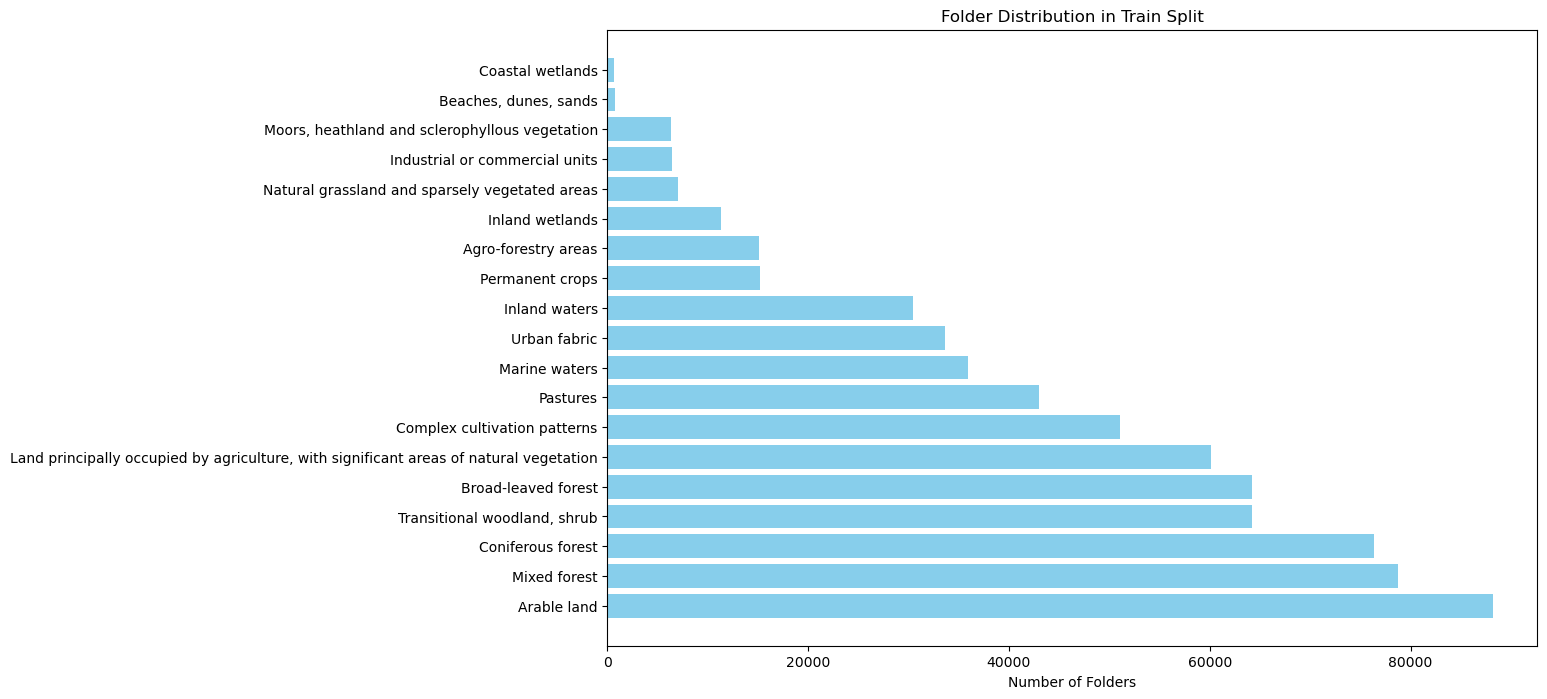

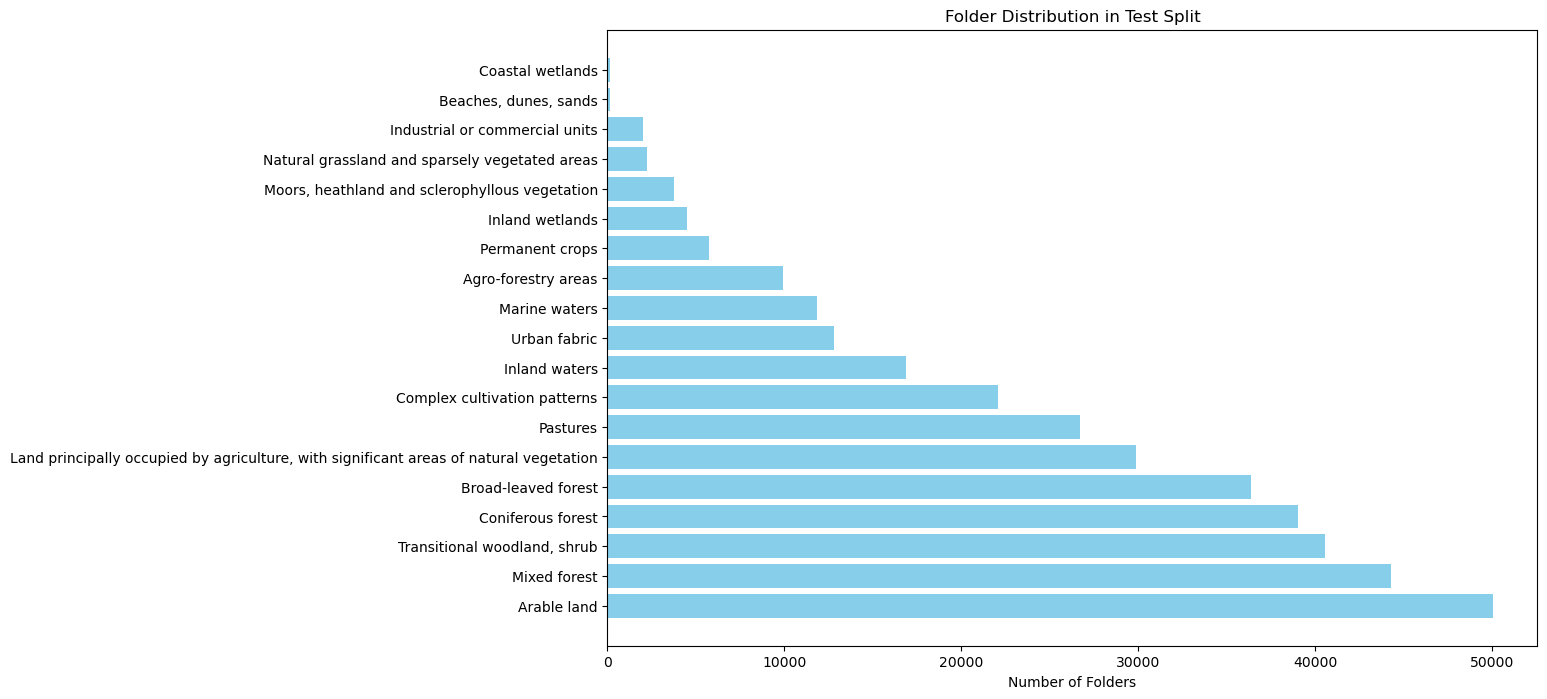

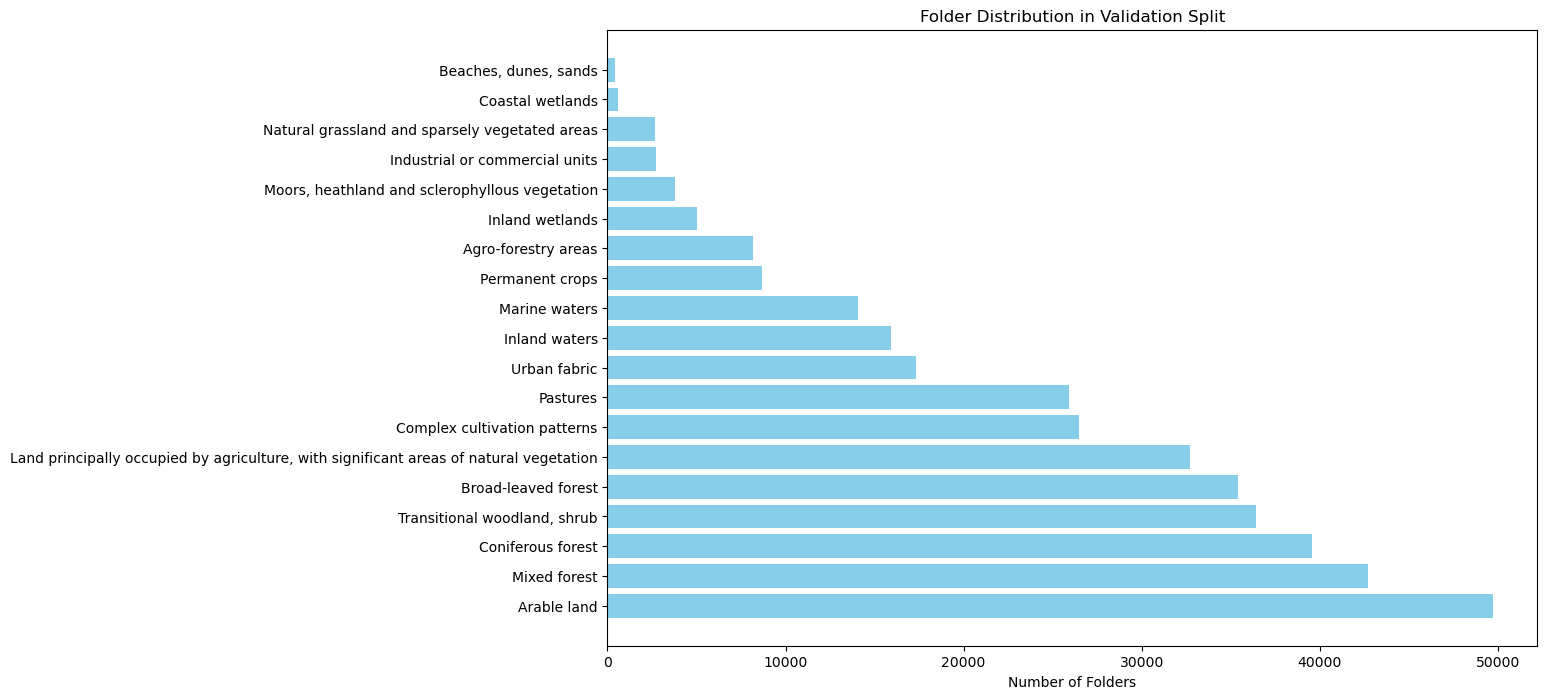

Number of folders in 'train': 688603
Number of folders in 'test': 358877
Number of folders in 'validation': 368358

Total number of folders: 1415838
Percentage of folders in 'train': 48.64%
Percentage of folders in 'test': 25.35%
Percentage of folders in 'validation': 26.02%


In [46]:
# Base directory paths
source_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset'
target_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\dataset_splits'
images_dir = r'C:\Users\isaac\FYPCode\images'

# Calculate the number of folders in each split and their distributions
try:
    train_category_counts = count_folders_in_split(target_base_dir, 'train')
    test_category_counts = count_folders_in_split(target_base_dir, 'test')
    valid_category_counts = count_folders_in_split(target_base_dir, 'validation')

    # Plot the distributions and save them as images in the images directory
    plot_category_distribution(train_category_counts, 'Train', save_path=os.path.join(images_dir, 'train_distribution.png'))
    plot_category_distribution(test_category_counts, 'Test', save_path=os.path.join(images_dir, 'test_distribution.png'))
    plot_category_distribution(valid_category_counts, 'Validation', save_path=os.path.join(images_dir, 'validation_distribution.png'))

    # Calculate the total number of folders
    total_folders_count = sum(train_category_counts.values()) + sum(test_category_counts.values()) + sum(valid_category_counts.values())

    # Calculate percentages
    train_percentage = (sum(train_category_counts.values()) / total_folders_count) * 100
    test_percentage = (sum(test_category_counts.values()) / total_folders_count) * 100
    valid_percentage = (sum(valid_category_counts.values()) / total_folders_count) * 100

    # Print results
    print(f"Number of folders in 'train': {sum(train_category_counts.values())}")
    print(f"Number of folders in 'test': {sum(test_category_counts.values())}")
    print(f"Number of folders in 'validation': {sum(valid_category_counts.values())}")

    print()
    print(f"Total number of folders: {total_folders_count}")

    print(f"Percentage of folders in 'train': {train_percentage:.2f}%")
    print(f"Percentage of folders in 'test': {test_percentage:.2f}%")
    print(f"Percentage of folders in 'validation': {valid_percentage:.2f}%")

except FileNotFoundError as e:
    print(e)

### Removal of Unwanted Folders

In [49]:
# Folder to keep
keep_folder = 'dataset_splits'

# Iterate over all items in the directory
for item in os.listdir(source_base_dir ):
    item_path = os.path.join(source_base_dir , item)
    
    # Check if the item is a directory and is not the folder to keep
    if os.path.isdir(item_path) and item != keep_folder:
        # Remove the directory and its contents
        shutil.rmtree(item_path)
        print(f'Removed folder: {item_path}')

print('Operation completed.')

Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Agro-forestry areas
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Arable land
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Broad-leaved forest
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Coastal wetlands
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Complex cultivation patterns
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Coniferous forest
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Industrial or commercial units
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Inland waters
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Inland wetlands
Removed folder: D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Land principally occupied by agriculture, with significant areas